In [1]:
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# UPDATE this path
BASE_DIR = r"E:\Early Crop Stress Prediction Before Visible Damage\Dataset"  # example

NDVI_DIR = os.path.join(BASE_DIR, "NDVI")
RGB_DIR  = os.path.join(BASE_DIR, "RGB")
VH_DIR   = os.path.join(BASE_DIR, "SAR", "VH")
VV_DIR   = os.path.join(BASE_DIR, "SAR", "VV")

print("NDVI path:", NDVI_DIR)
print("RGB path :", RGB_DIR)
print("VH path  :", VH_DIR)
print("VV path  :", VV_DIR)


NDVI path: E:\Early Crop Stress Prediction Before Visible Damage\Dataset\NDVI
RGB path : E:\Early Crop Stress Prediction Before Visible Damage\Dataset\RGB
VH path  : E:\Early Crop Stress Prediction Before Visible Damage\Dataset\SAR\VH
VV path  : E:\Early Crop Stress Prediction Before Visible Damage\Dataset\SAR\VV


In [3]:
ndvi_files = sorted(os.listdir(NDVI_DIR))
rgb_files  = sorted(os.listdir(RGB_DIR))
vh_files   = sorted(os.listdir(VH_DIR))
vv_files   = sorted(os.listdir(VV_DIR))

print("Total NDVI images:", len(ndvi_files))
print("Total RGB images :", len(rgb_files))
print("Total SAR-VH     :", len(vh_files))
print("Total SAR-VV     :", len(vv_files))

# Find common filenames across all modalities
common_files = sorted(list(set(ndvi_files) & set(rgb_files) & set(vh_files) & set(vv_files)))

print("\nImages aligned across all modalities:", len(common_files))


Total NDVI images: 2200
Total RGB images : 2200
Total SAR-VH     : 2200
Total SAR-VV     : 2200

Images aligned across all modalities: 2200


In [4]:
def load_tif(path, size=(128,128)):
    with rasterio.open(path) as src:
        img = src.read(1)
    img = cv2.resize(img, size)
    img = img.astype(np.float32)

    # Min–Max normalization
    if img.max() > img.min():
        img = (img - img.min()) / (img.max() - img.min())
    else:
        img = np.zeros_like(img)

    return img


In [5]:
sample_name = common_files[0]

ndvi = load_tif(os.path.join(NDVI_DIR, sample_name))
vh   = load_tif(os.path.join(VH_DIR, sample_name))
vv   = load_tif(os.path.join(VV_DIR, sample_name))
rgb  = cv2.imread(os.path.join(RGB_DIR, sample_name))
rgb  = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb  = cv2.resize(rgb, (128,128)) / 255.0

print("NDVI shape:", ndvi.shape)
print("RGB shape :", rgb.shape)
print("VH shape  :", vh.shape)
print("VV shape  :", vv.shape)


NDVI shape: (128, 128)
RGB shape : (128, 128, 3)
VH shape  : (128, 128)
VV shape  : (128, 128)


c:\Users\vishm\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


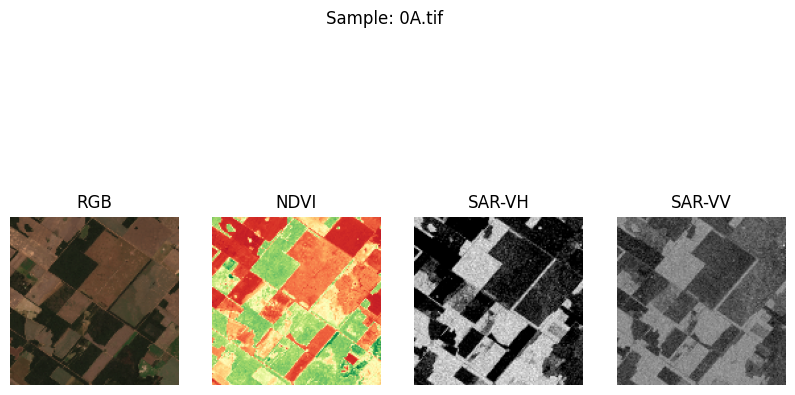

In [6]:
plt.figure(figsize=(10,6))

plt.subplot(1,4,1)
plt.imshow(rgb)
plt.title("RGB")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(ndvi, cmap="RdYlGn")
plt.title("NDVI")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(vh, cmap="gray")
plt.title("SAR-VH")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(vv, cmap="gray")
plt.title("SAR-VV")
plt.axis("off")

plt.suptitle(f"Sample: {sample_name}")
plt.show()


In [7]:
data = []

for name in common_files:
    ndvi = load_tif(os.path.join(NDVI_DIR, name))
    vh   = load_tif(os.path.join(VH_DIR, name))
    vv   = load_tif(os.path.join(VV_DIR, name))

    rgb  = cv2.imread(os.path.join(RGB_DIR, name))
    rgb  = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    rgb  = cv2.resize(rgb, (128,128)) / 255.0

    data.append({
        "file": name,
        "ndvi": ndvi,
        "vh": vh,
        "vv": vv,
        "rgb": rgb
    })

print("Total loaded samples:", len(data))


Total loaded samples: 2200


In [8]:
def compute_exg(rgb):
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]
    return np.mean(2*G - R - B)

eda_rows = []

for sample in data:
    eda_rows.append({
        "file": sample["file"],
        "ndvi_mean": np.mean(sample["ndvi"]),
        "ndvi_std":  np.std(sample["ndvi"]),
        "vh_mean":   np.mean(sample["vh"]),
        "vv_mean":   np.mean(sample["vv"]),
        "exg_mean":  compute_exg(sample["rgb"])
    })

eda_df = pd.DataFrame(eda_rows)

print("EDA DataFrame shape:", eda_df.shape)
display(eda_df.head())


EDA DataFrame shape: (2200, 6)


,file,ndvi_mean,ndvi_std,vh_mean,vv_mean,exg_mean
0,0A.tif,0.413902,0.247326,0.333457,0.371592,0.015441
1,0B.tif,0.397767,0.269803,0.267183,0.446331,0.032057
2,1000A.tif,0.903301,0.103477,0.569467,0.619824,0.110793
3,1000B.tif,0.778997,0.143471,0.601373,0.580988,0.144539
4,1001A.tif,0.433612,0.145106,0.437680,0.335837,0.022112


In [9]:
eda_df.describe()


,ndvi_mean,ndvi_std,vh_mean,vv_mean,exg_mean
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,0.626907,0.146449,0.434898,0.495737,0.071254
std,0.168576,0.053355,0.158019,0.106378,0.052045
min,0.115048,0.025295,0.000000,0.102245,-0.076999
25%,0.510389,0.110327,0.342436,0.427334,0.033497
50%,0.644306,0.140230,0.452683,0.494679,0.073410
75%,0.755384,0.176059,0.550195,0.561993,0.109065
max,0.965733,0.395002,0.826922,0.853736,0.292947


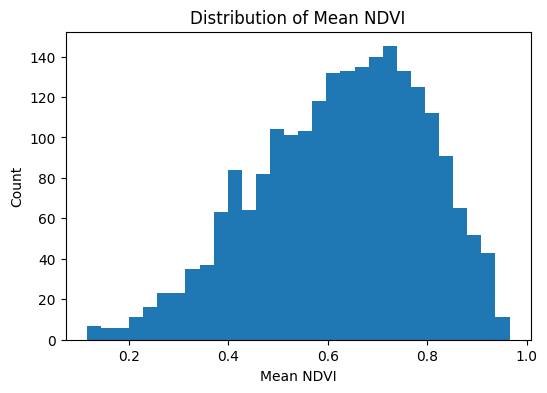

In [10]:
plt.figure(figsize=(6,4))
plt.hist(eda_df["ndvi_mean"], bins=30)
plt.xlabel("Mean NDVI")
plt.ylabel("Count")
plt.title("Distribution of Mean NDVI")
plt.show()


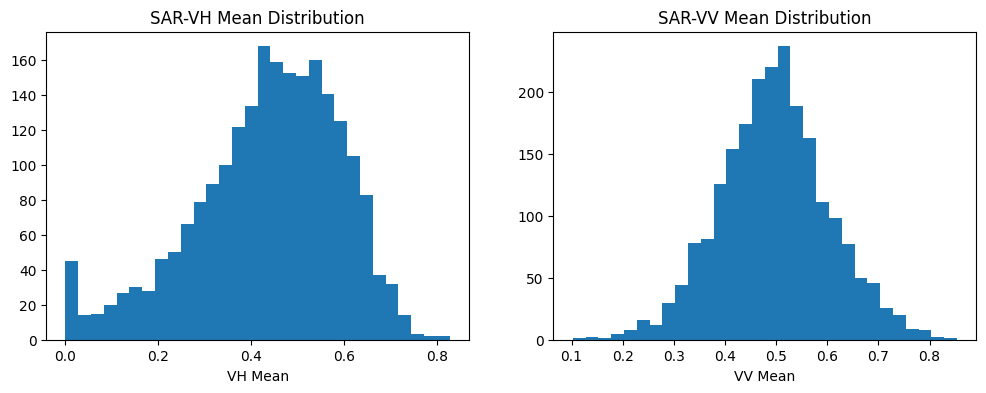

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(eda_df["vh_mean"], bins=30)
plt.title("SAR-VH Mean Distribution")
plt.xlabel("VH Mean")

plt.subplot(1,2,2)
plt.hist(eda_df["vv_mean"], bins=30)
plt.title("SAR-VV Mean Distribution")
plt.xlabel("VV Mean")

plt.show()


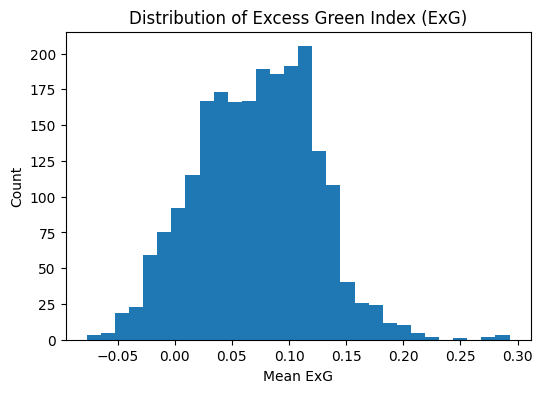

In [12]:
plt.figure(figsize=(6,4))
plt.hist(eda_df["exg_mean"], bins=30)
plt.xlabel("Mean ExG")
plt.ylabel("Count")
plt.title("Distribution of Excess Green Index (ExG)")
plt.show()


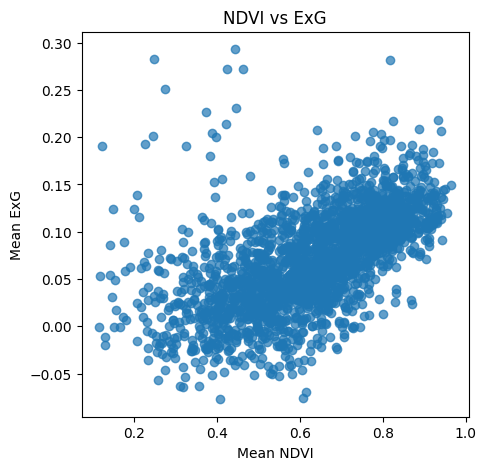

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(eda_df["ndvi_mean"], eda_df["exg_mean"], alpha=0.7)
plt.xlabel("Mean NDVI")
plt.ylabel("Mean ExG")
plt.title("NDVI vs ExG")
plt.show()


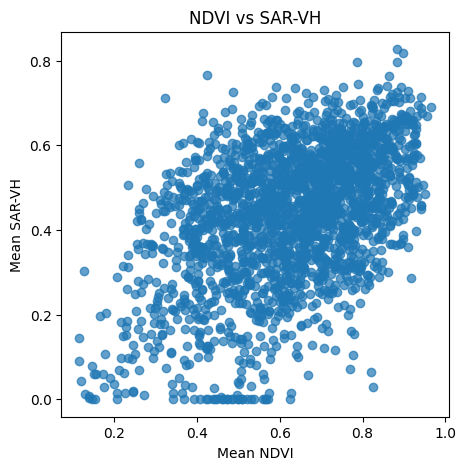

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(eda_df["ndvi_mean"], eda_df["vh_mean"], alpha=0.7)
plt.xlabel("Mean NDVI")
plt.ylabel("Mean SAR-VH")
plt.title("NDVI vs SAR-VH")
plt.show()


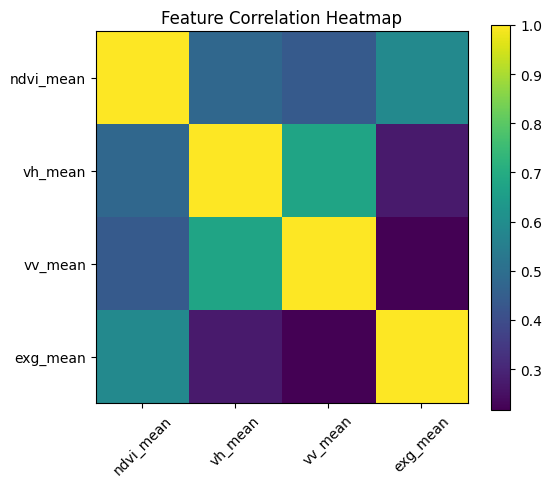

In [15]:
corr = eda_df[["ndvi_mean","vh_mean","vv_mean","exg_mean"]].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap")
plt.show()


In [16]:
eda_df.to_csv("eda_summary.csv", index=False)
print("EDA summary saved as eda_summary.csv")


EDA summary saved as eda_summary.csv
